In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import torchview
import tqdm

In [2]:
def generate_samples(size, ratio=0.5):
    u_1 = -4
    label_1 = 0
    x_1 = np.random.normal(u_1, 1, int(size * ratio))
    y_1 = np.ones(int(size * ratio)) *label_1

    u_2 = 4
    label_2 = 1
    x_2 = np.random.normal(u_2, 1, int(size * (1-ratio)))
    y_2 = np.ones(int(size * (1 - ratio))) *label_2

    
    x = np.concatenate([x_1, x_2], axis=0)
    y = np.concatenate([y_1, y_2], axis=0)

    X = np.concatenate([x[...,np.newaxis], y[...,np.newaxis]], axis=1)

    np.random.seed(0)
    np.random.shuffle(X)
    return X
    
generate_samples(10)

array([[-4.49672476,  0.        ],
       [ 2.45456973,  1.        ],
       [-4.60068886,  0.        ],
       [ 5.47423523,  1.        ],
       [-5.2143331 ,  0.        ],
       [ 4.24670641,  1.        ],
       [ 3.09271363,  1.        ],
       [-3.57082304,  0.        ],
       [-4.07336774,  0.        ],
       [ 4.11882955,  1.        ]])

In [3]:
num_samples = 1000
train = torch.from_numpy(generate_samples(num_samples)).float()
val = torch.from_numpy(generate_samples(num_samples // 10)).float()
test = torch.from_numpy(generate_samples(num_samples)).float()

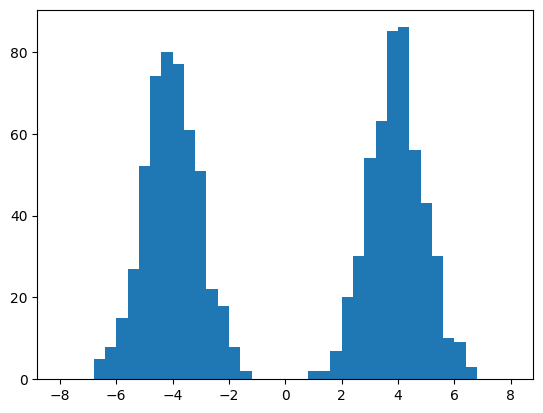

In [4]:
# these are perfectly distunguishable classes
plt.hist(train[:,0], bins=40, range=(-8, 8))
plt.show()

In [5]:
loss = torch.nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)

In [6]:
c_loss = torch.nn.CrossEntropyLoss(reduction='none')
input = torch.tensor([[0.2, 0.8], [0.8, 0.2], [1.0, 0.0], [0.0, 1.0]])
target = torch.tensor([1, 1, 1, 1]) # actual target is 1
c_loss(input, target)

tensor([0.4375, 1.0375, 1.3133, 0.3133])

In [7]:
torch.nn.LogSoftmax()(input) # The true answer is 

/home/rushi/dev/test_venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[-1.0375, -0.4375],
        [-0.4375, -1.0375],
        [-0.3133, -1.3133],
        [-1.3133, -0.3133]])

In [8]:
def softmax(x):
    num = np.exp(x)
    denom = num.sum()
    return num/denom

softmax(np.array([1,0, -1]))

array([0.66524096, 0.24472847, 0.09003057])

In [9]:
softmax([-1, 0, 10])

array([1.67006637e-05, 4.53971105e-05, 9.99937902e-01])

/home/rushi/dev/test_venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


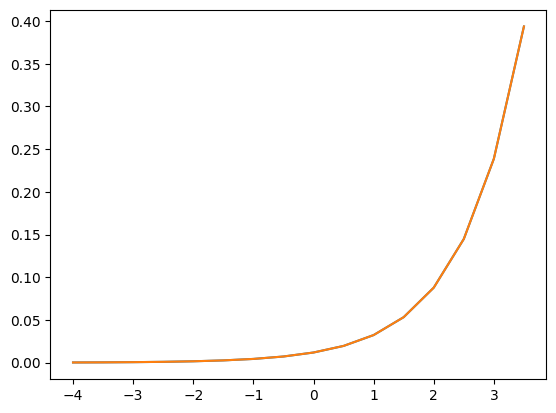

In [10]:
x = np.arange(-4,4,0.5, dtype=np.float32)
plt.plot(x, torch.nn.Softmax()(torch.from_numpy(x)))
plt.plot(x, softmax(x))

/tmp/ipykernel_212886/22307643.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, np.log(x))


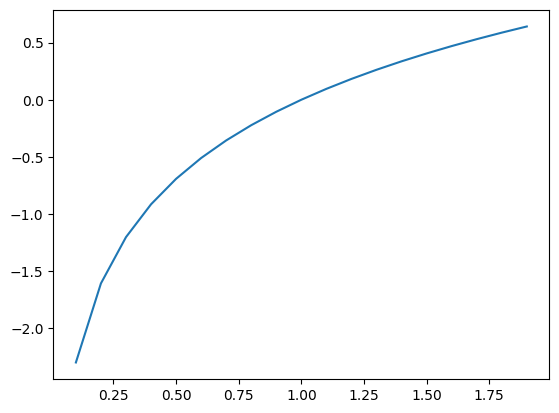

In [11]:
x = np.arange(0, 2, 0.1)
plt.plot(x, np.log(x))

In [12]:
class Classifier(torch.nn.Module):
    def __init__(self, num_classes):
        super(Classifier, self).__init__()
        self.model = torch.nn.Sequential(torch.nn.Linear(1,1, bias=False), # single neuron class
                                         torch.nn.LeakyReLU(0.2),
                                         torch.nn.Linear(1,num_classes),
                                         torch.nn.Softmax(dim=1),
                                        )

    def forward(self, x):
        return self.model(x)

num_classes = 2
model = Classifier(num_classes=2)

model(torch.rand(2, 1))

tensor([[0.2073, 0.7927],
        [0.2074, 0.7926]], grad_fn=<SoftmaxBackward0>)

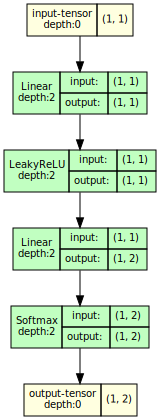

In [13]:
graph = torchview.draw_graph(model, torch.rand(1,1))
graph.visual_graph

In [14]:
print(model)

Classifier(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=1, out_features=2, bias=True)
    (3): Softmax(dim=1)
  )
)


In [15]:
train[0:2, :]

tensor([[3.6419, 1.0000],
        [2.9833, 1.0000]])

In [16]:
# reinstantiate model and train
model = Classifier(num_classes=2)
optim = torch.optim.SGD(model.parameters())
num_epochs = 100
chunk_size = 50

eval_losses = []
best_loss = torch.inf
epochs_without_loss_improvement = 0
max_epochs = 500
for ii in tqdm.tqdm(range(max_epochs)):
    for jj in range((len(train) // chunk_size)):
        all = train[chunk_size*jj : chunk_size*(jj+1)]
        x, y = all[:, [0]], all[:, 1].to(torch.long)
        yhat = model(x)
        loss = torch.nn.CrossEntropyLoss()(yhat, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    with torch.no_grad():
        yhat = model(val[:, [0]])
        loss = torch.nn.CrossEntropyLoss()(yhat, val[:, 1].to(torch.long))   
        eval_losses.append(loss)
        if loss < best_loss:
            best_loss = loss
            epochs_without_loss_improvement = 0
        else:
            epochs_without_loss_improvement += 1
        if epochs_without_loss_improvement == 5:
            break
act_epochs = min(max_epochs, ii+1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.42it/s]


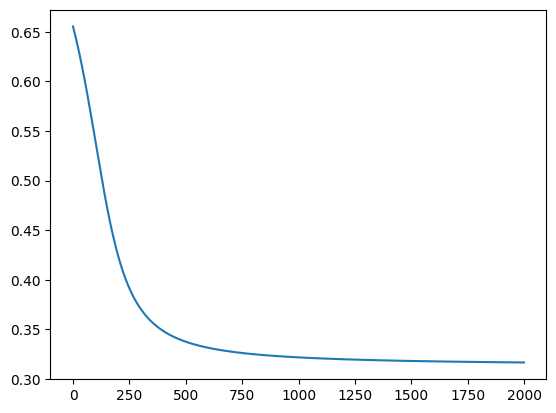

In [17]:
plt.plot(range(act_epochs), eval_losses)

In [18]:
# test the model
model.eval()
test_yhat = model(test[:, [0]])
test_classes_yhat =  test_yhat.argmax(dim=1)

In [19]:
# metrics
actual_classes = test[:, 1].to(torch.long)
accuracy = (test_classes_yhat == actual_classes).sum() / (actual_classes.shape[0])
print(accuracy)

tensor(1.)


In [20]:
# investigate the model

In [21]:
model.state_dict()

OrderedDict([('model.0.weight', tensor([[-1.8982]])),
             ('model.2.weight',
              tensor([[ 1.4567],
                      [-1.2349]])),
             ('model.2.bias', tensor([-0.0624,  0.5253]))])

torch.Size([1000, 1])
torch.Size([2, 1]) tensor([[ 1.4567],
        [-1.2349]])
torch.Size([1000])


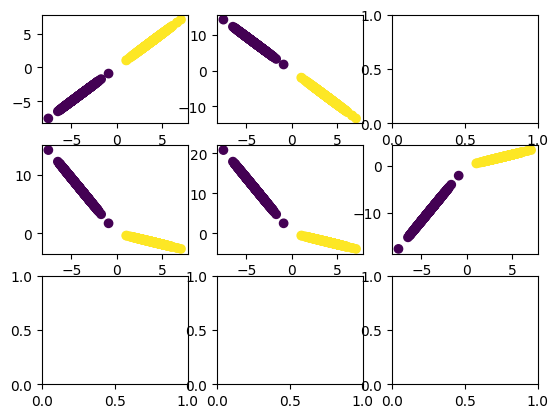

In [22]:
fig, axs = plt.subplots(nrows=3, ncols=3, layout=None)
axs[0,0].scatter(test[:, [0]], test[:, [0]], c=test[:, [1]])
post_linear = test[:, [0]] * model.state_dict()['model.0.weight']
axs[0,1].scatter(test[:, [0]], post_linear, c=test[:, [1]])
post_relu = torch.nn.LeakyReLU(0.2)(post_linear)
axs[1,0].scatter(test[:, [0]], post_relu, c=test[:, [1]])
print(post_relu.shape)
print(model.state_dict()['model.2.weight'].shape,model.state_dict()['model.2.weight'] )
post_final = model.state_dict()['model.2.weight'].T * post_relu
post_final_class_0 = post_final[:, 0]
post_final_class_1 = post_final[:, 1]
print(post_final_class_0.shape)
axs[1,1].scatter(test[:, [0]], post_final_class_0, c=test[:, [1]]) # for points which are truly class 0, there are non negative values. Class 1 points all have -ve values.
axs[1,2].scatter(test[:, [0]], post_final_class_1, c=test[:, [1]]) # for points which are class 0, there are -ve values. Class 1 points have +ve weights which will translate to high prob values post softmax.

In [23]:
# draw how the model evolves over time
# draw how the model separates N colors over time


In [24]:
# figure out separation of multiple classes all close in color

In [25]:
def generate_samples(size, num_classes=5):
    ys = torch.empty(size, dtype=torch.int8).random_(num_classes)
    xs = torch.normal(ys.float()*5, std=torch.ones_like(ys)).unsqueeze(-1)
    return xs, ys

torch.Size([100, 1]) torch.Size([100])


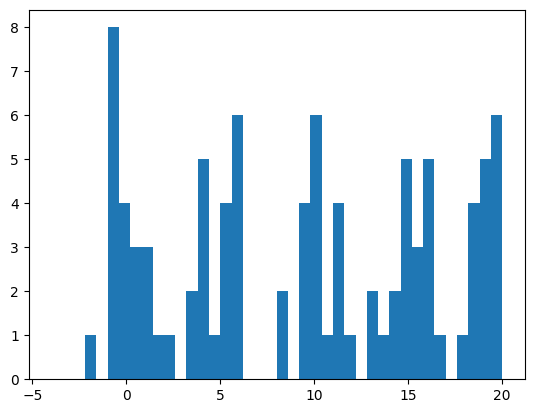

In [26]:
xs, ys = generate_samples(100)
print(xs.shape, ys.shape)
a = plt.hist(xs.squeeze(), bins=40, range=(-4, 20))

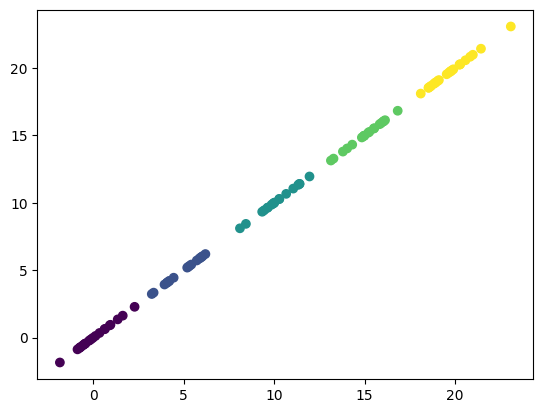

In [27]:
plt.scatter(xs, xs, c=ys)

In [28]:
num_train_samples = 10000
num_classes = 5
xs_train, ys_train = generate_samples(num_train_samples, num_classes=num_classes)
xs_val, ys_val = generate_samples(num_samples // 10, num_classes=num_classes)

In [29]:
from IPython.display import clear_output


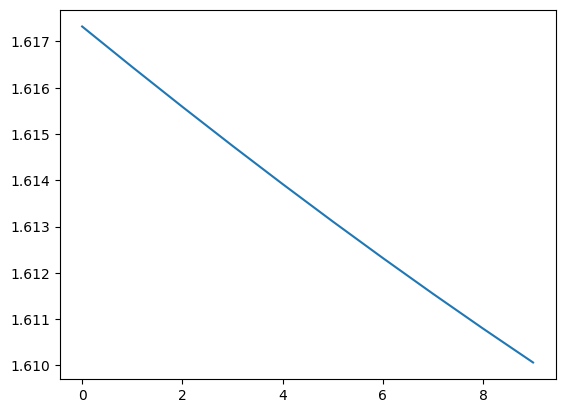

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.23it/s]


In [30]:
# reinstantiate model and train
model = Classifier(num_classes=num_classes)
optim = torch.optim.Adam(model.parameters()) # Using Adam instead of SGD
num_epochs = 100
chunk_size = 500

eval_losses = []
best_loss = torch.inf
epochs_without_loss_improvement = 0
max_epochs = 10
for ii in tqdm.tqdm(range(max_epochs)):
    for jj in range((len(train) // chunk_size)):
        x = xs_train[chunk_size*jj : chunk_size*(jj+1)]
        y = ys_train[chunk_size*jj : chunk_size*(jj+1)].to(torch.long)        
        yhat = model(x)
        loss = torch.nn.CrossEntropyLoss()(yhat, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    with torch.no_grad():
        yhat = model(xs_val)
        loss = torch.nn.CrossEntropyLoss()(yhat, ys_val.to(torch.long))   
        eval_losses.append(loss)
        if loss < best_loss:
            best_loss = loss
            epochs_without_loss_improvement = 0
        else:
            epochs_without_loss_improvement += 1
        if epochs_without_loss_improvement == 5:
            break
        clear_output(wait=True)
        plt.plot(range(ii+1), eval_losses)
        plt.show()
act_epochs = min(max_epochs, ii+1)


In [31]:
def create_model_and_train(model, optim, train_loader, eval_data, max_epochs):
    eval_losses = []
    best_loss = torch.inf
    epochs_without_loss_improvement = 0    
    num_steps = 0
    for ii in tqdm.tqdm(range(max_epochs)):
        train_it = iter(train_loader)
        try:
            while True:
                x, y == next(train_it)
                yhat = model(x)
                loss = torch.nn.CrossEntropyLoss()(yhat, y)
                optim.zero_grad()
                loss.backward()
                optim.step()
                num_steps +=1
        except StopIteration:
            pass
                
        with torch.no_grad():
            yhat = model(eval_data[0])
            loss = torch.nn.CrossEntropyLoss()(yhat, eval_data[1].to(torch.long))
            eval_losses.append(loss)
            if loss < best_loss:
                best_loss = loss
                epochs_without_loss_improvement = 0
            else:
                epochs_without_loss_improvement += 1
            if epochs_without_loss_improvement == 5:
                print("Exiting without improvement")
                break
            #clear_output(wait=True)
            #plt.plot(range(ii+1), eval_losses)
            #plt.show()
    act_epochs = min(max_epochs, ii+1)
    return model, eval_losses

In [32]:
num_classes = 5
model = Classifier(num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters())

class MyDS(torch.utils.data.IterableDataset):
    def __init__(self, xs, ys, batch_size):
        self.xs = xs
        self.ys = ys
        self.batch_size = batch_size

    def __iter__(self):
        for ii in range(self.xs.shape[0] // self.batch_size):
            x, y = self.xs[ii*self.batch_size:(ii+1)*self.batch_size], self.ys[ii*self.batch_size:(ii+1)*self.batch_size].to(torch.long)            
            yield x,y
    
    def __len__(self):
        return self.xs.shape[0]

train_loader = torch.utils.data.DataLoader(MyDS(*generate_samples(10000, num_classes=num_classes), 50), batch_size=None)
eval_data = generate_samples(1000, num_classes=num_classes)
model, losses = create_model_and_train(model, optimizer, train_loader, eval_data, max_epochs=100)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.83it/s]


In [33]:
model.state_dict()

OrderedDict([('model.0.weight', tensor([[2.4003]])),
             ('model.2.weight',
              tensor([[-1.8052],
                      [-0.1039],
                      [ 1.1561],
                      [-1.5251],
                      [-1.1986]])),
             ('model.2.bias',
              tensor([ 15.7723,   6.6035, -15.7791,  -2.0080,  -2.7063]))])

tensor(0.5950)
tensor([[2, 4],
        [2, 2],
        [0, 0],
        ...,
        [2, 3],
        [2, 4],
        [0, 0]])
tensor(177)
tensor(194)


(array([177.,   0., 196.,   0.,   0., 230.,   0., 203.,   0., 194.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

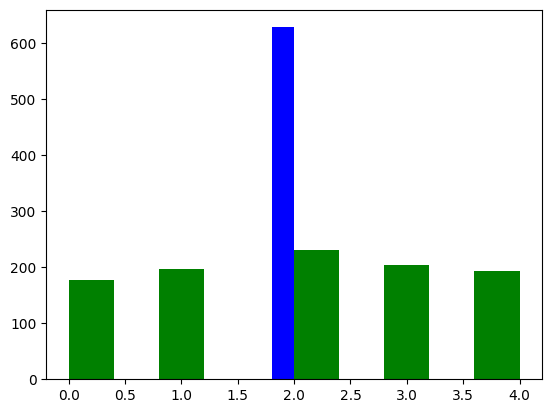

In [34]:
test_data = generate_samples(1000, num_classes=num_classes)
model_out = model(test_data[0])
class_out = model_out.argmax(dim=1)
accuracy = (class_out == test_data[1]).sum()/test_data[0].shape[0]
print(accuracy)
print(torch.cat([class_out.unsqueeze(-1), test_data[1].unsqueeze(-1)], dim=1))
print((test_data[1] == 0.0).sum())
print((test_data[1] == 4.0).sum())
plt.hist(class_out, color='blue') # classes 2 and 3 are simply classified as class 1 since the network cannot express itself better using a single neuron and the final set of biases
plt.hist(test_data[1], color='green')

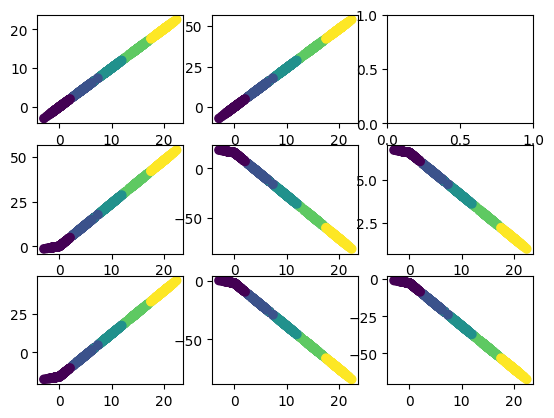

In [35]:
fig, axs = plt.subplots(nrows=3, ncols=3, layout=None)
axs[0,0].scatter(test_data[0], test_data[0], c=test_data[1])
post_linear = test_data[0] * model.state_dict()['model.0.weight']
axs[0,1].scatter(test_data[0], post_linear, c=test_data[1])
post_relu = torch.nn.LeakyReLU(0.2)(post_linear)
axs[1,0].scatter(test_data[0], post_relu, c=test_data[1])
post_final = model.state_dict()['model.2.weight'].T * post_relu + model.state_dict()['model.2.bias'] # The bias allows for the classification of one more class [0,1,4]
post_final_class_0 = post_final[:, 0]
post_final_class_1 = post_final[:, 1]
post_final_class_2 = post_final[:, 2]
post_final_class_3 = post_final[:, 3]
post_final_class_4 = post_final[:, 4]

axs[1,1].scatter(test_data[0], post_final_class_0, c=test_data[1])
axs[1,2].scatter(test_data[0], post_final_class_1, c=test_data[1])
axs[2,0].scatter(test_data[0], post_final_class_2, c=test_data[1])
axs[2,1].scatter(test_data[0], post_final_class_3, c=test_data[1])
axs[2,2].scatter(test_data[0], post_final_class_4, c=test_data[1])

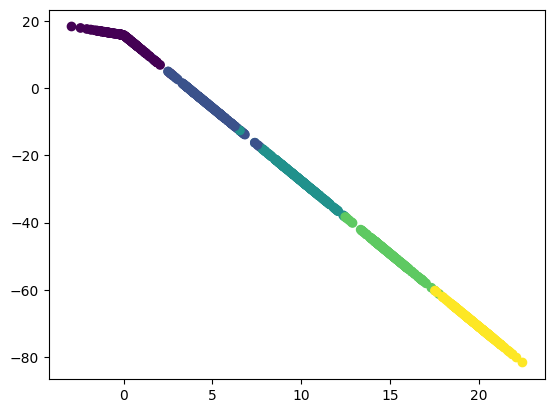

In [36]:
plt.scatter(test_data[0], post_final_class_0, c=test_data[1])

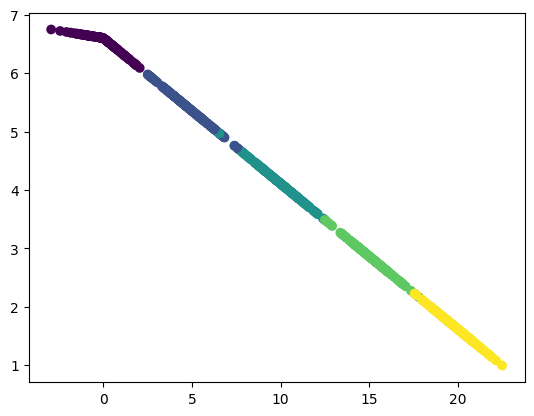

In [37]:
plt.scatter(test_data[0], post_final_class_1, c=test_data[1])

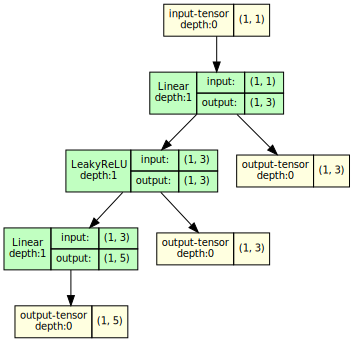

In [46]:
# Need to allow the classifier to have more kinks in the output

class ClassifierV2(torch.nn.Module):
    def __init__(self, num_classes, layer_size):
        super(ClassifierV2, self).__init__()
        self.layer_1 = torch.nn.Linear(1, layer_size)
        self.layer_2 = torch.nn.Linear(layer_size, num_classes)

    def forward(self, x):
        out_1 = self.layer_1(x)
        out_1_relu = torch.nn.LeakyReLU(0.2)(out_1)
        out_2 = self.layer_2(out_1_relu)
        return {'res': out_2, 'out_1': out_1, 'out_1_relu': out_1_relu}
model = ClassifierV2(num_classes=5, layer_size=3)
torchview.draw_graph(model, torch.rand(1,1)).visual_graph

In [47]:
def create_model_and_trainv2(model, optim, train_loader, eval_data, max_epochs):
    eval_losses = []
    best_loss = torch.inf
    epochs_without_loss_improvement = 0    
    num_steps = 0
    for ii in tqdm.tqdm(range(max_epochs)):
        train_it = iter(train_loader)
        try:
            while True:
                x, y == next(train_it)
                yhat = model(x)['res']
                loss = torch.nn.CrossEntropyLoss()(yhat, y)
                optim.zero_grad()
                loss.backward()
                optim.step()
                num_steps +=1
        except StopIteration:
            pass
                
        with torch.no_grad():
            yhat = model(eval_data[0])['res']
            loss = torch.nn.CrossEntropyLoss()(yhat, eval_data[1].to(torch.long))
            eval_losses.append(loss)
            if loss < best_loss:
                best_loss = loss
                epochs_without_loss_improvement = 0
            else:
                epochs_without_loss_improvement += 1
            if epochs_without_loss_improvement == 5:
                print("Exiting without improvement")
                break
            clear_output(wait=True)
            plt.plot(range(ii+1), eval_losses)
            plt.show()
    act_epochs = min(max_epochs, ii+1)
    return model, eval_losses

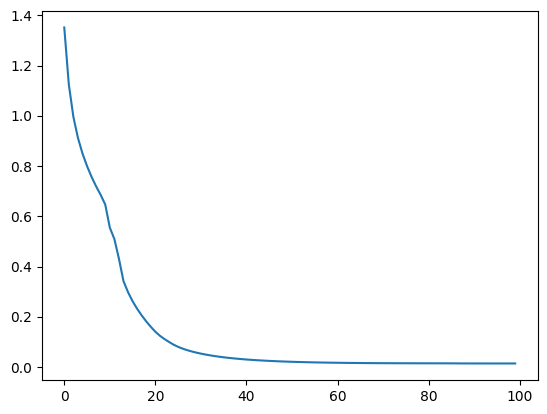

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.83it/s]


In [48]:
model = ClassifierV2(num_classes=num_classes, layer_size=3)
optimizer = torch.optim.Adam(model.parameters())
train_loader = torch.utils.data.DataLoader(MyDS(*generate_samples(10000, num_classes=num_classes), 50), batch_size=None)
eval_data = generate_samples(1000, num_classes=num_classes)
model, losses = create_model_and_trainv2(model, optimizer, train_loader, eval_data, max_epochs=100)

tensor(0.9960)


(array([202.,   0., 201.,   0.,   0., 213.,   0., 171.,   0., 213.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

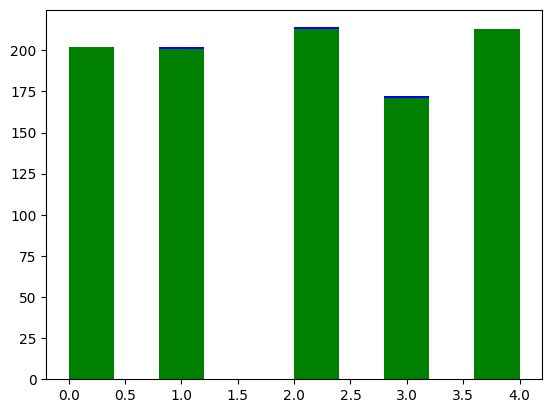

In [49]:
test_data = generate_samples(1000, num_classes=num_classes)
model.eval()
model_out = model(test_data[0])['res']
class_out = model_out.argmax(dim=1)
accuracy = (class_out == test_data[1]).sum()/test_data[0].shape[0]
print(accuracy)
plt.hist(class_out, color='blue') # classes 2 and 3 are simply classified as class 1 since the network cannot express itself better using a single neuron and the final set of biases
plt.hist(test_data[1], color='green')

In [50]:
model.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.5334],
                      [-0.9450],
                      [-3.9611]])),
             ('layer_1.bias', tensor([10.2113,  6.6120,  9.2383])),
             ('layer_2.weight',
              tensor([[ 5.7481,  3.8164,  5.9812],
                      [ 7.2108,  2.0358,  2.9911],
                      [ 4.9428, -4.4753, -0.2977],
                      [ 0.3757, -1.3514, -3.0000],
                      [-8.2324, -5.2841, -3.3422]])),
             ('layer_2.bias',
              tensor([ 6.3643,  1.6800,  2.7368,  0.0327, -3.8866]))])

dict_keys(['res', 'out_1', 'out_1_relu'])


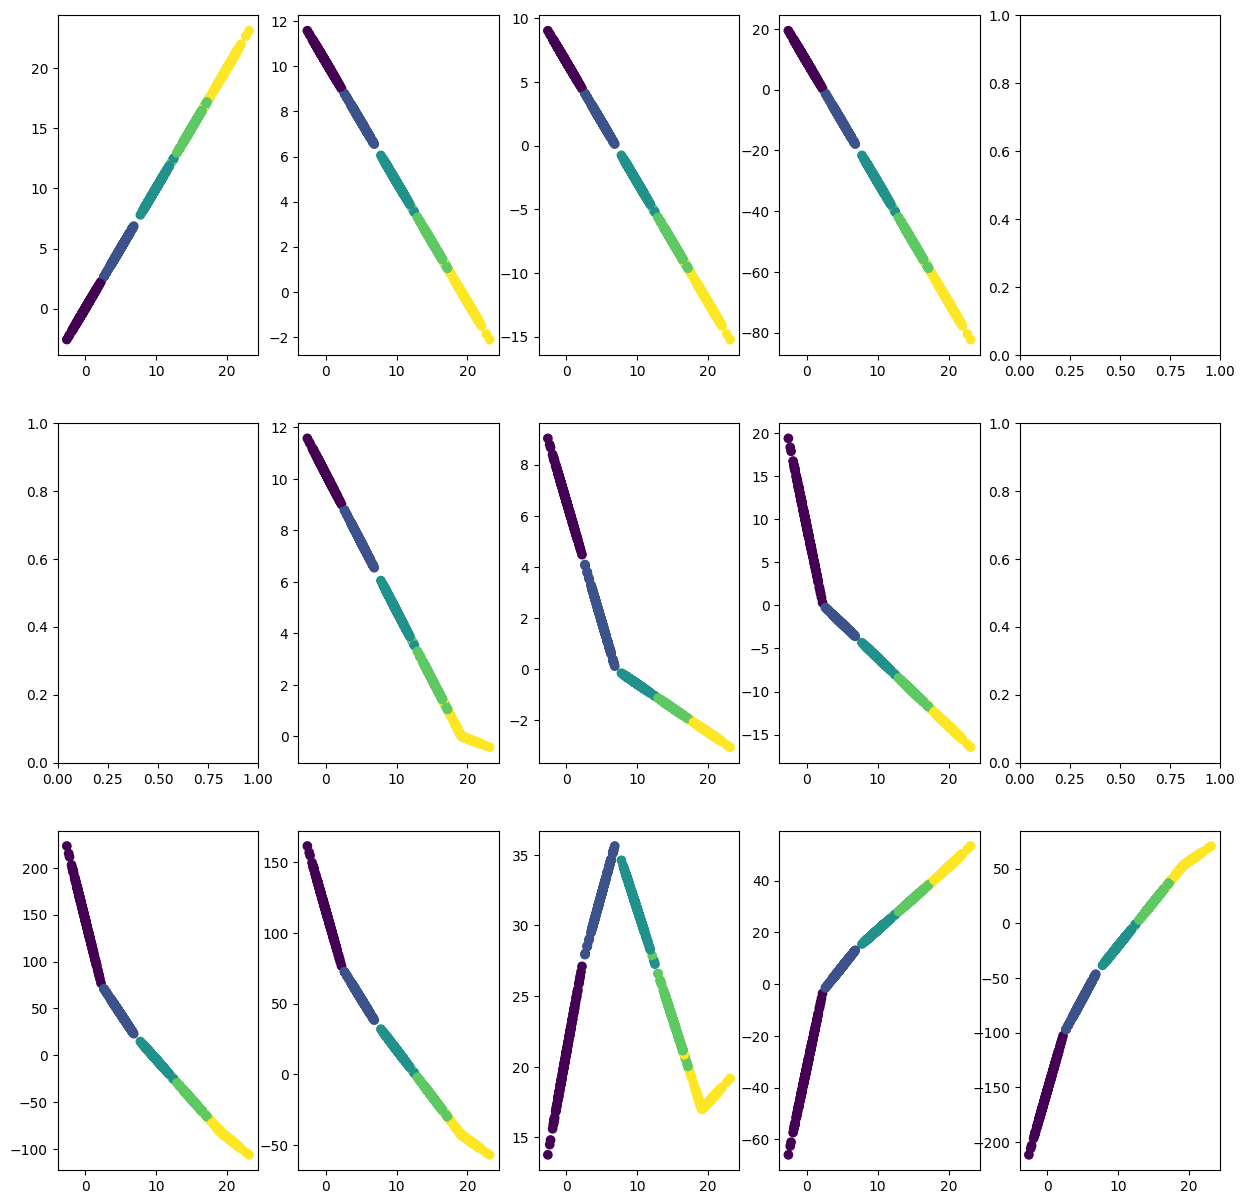

In [51]:
model_out = model(test_data[0])
print(model_out.keys())
out_1 = model_out['out_1'].detach().numpy()
out_1_relu = model_out['out_1_relu'].detach().numpy()
res = model_out['res'].detach().numpy()
fig, axs = plt.subplots(nrows=3, ncols=5, layout=None)
fig.set_figheight(15)
fig.set_figwidth(15)
axs[0,0].scatter(test_data[0], test_data[0], c=test_data[1])
axs[0,1].scatter(test_data[0], out_1[:,0], c=test_data[1])
axs[0,2].scatter(test_data[0], out_1[:,1], c=test_data[1])
axs[0,3].scatter(test_data[0], out_1[:,2], c=test_data[1])

#axs[1,0].scatter(test_data[0], test_data[0], c=test_data[1])
axs[1,1].scatter(test_data[0], out_1_relu[:,0], c=test_data[1])
axs[1,2].scatter(test_data[0], out_1_relu[:,1], c=test_data[1])
axs[1,3].scatter(test_data[0], out_1_relu[:,2], c=test_data[1])

axs[2,0].scatter(test_data[0], res[:,0], c=test_data[1])
axs[2,1].scatter(test_data[0], res[:,1], c=test_data[1])
axs[2,2].scatter(test_data[0], res[:,2], c=test_data[1])
axs[2,3].scatter(test_data[0], res[:,3], c=test_data[1])
axs[2,4].scatter(test_data[0], res[:,4], c=test_data[1])


In [71]:
# For a given point that belongs to a class, all that's important is that it score's the highest in it's own classes' neurons compared to all the other classes.
# it's relative value to itself in the other neurons is all that matters.
# Example for class (1) i.e color blue, even though it scores less than purple in the class 1 neuron, it relatively has the highest score compared to it's value in all other neurons.

# See post soft max value below

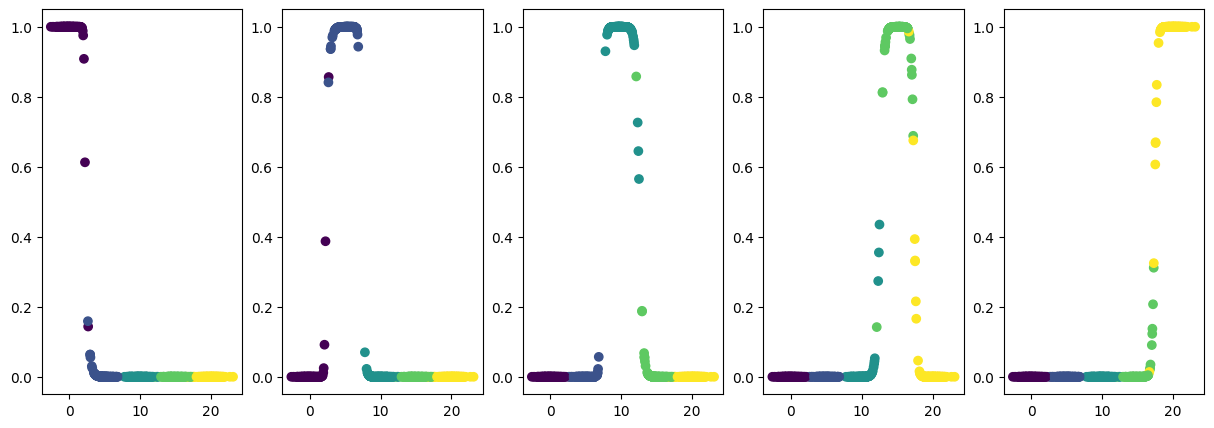

In [73]:
soft_max_res = torch.nn.Softmax(dim=1)( model_out['res']).detach().numpy()
fig, axs = plt.subplots(nrows=1, ncols=5, layout=None)
fig.set_size_inches(15, 5)

axs[0].scatter(test_data[0], soft_max_res[:,0], c=test_data[1])
axs[1].scatter(test_data[0], soft_max_res[:,1], c=test_data[1])
axs[2].scatter(test_data[0], soft_max_res[:,2], c=test_data[1])
axs[3].scatter(test_data[0], soft_max_res[:,3], c=test_data[1])
axs[4].scatter(test_data[0], soft_max_res[:,4], c=test_data[1])

In [52]:
# Per class accuracy
accuracy = (class_out == test_data[1]).sum()/test_data[0].shape[0]
print(accuracy)

tensor(0.9960)


In [53]:
def accuracy(yhat , y):
    return (yhat == y).sum()/yhat.shape[0]
    
for ii in range(num_classes):
    mask = (test_data[1] == ii)
    acc = accuracy(test_data[1][mask], class_out[mask])
    print(f"Accuracy for class {ii} is {acc}")

Accuracy for class 0 is 0.9950494766235352
Accuracy for class 1 is 1.0
Accuracy for class 2 is 1.0
Accuracy for class 3 is 0.9941520690917969
Accuracy for class 4 is 0.9906103014945984
